In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
from skimage.transform import resize
from skimage.io import imread, imsave

/Users/myZZUNG/myworkspace/kaggle-study/jupyter/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/myZZUNG/myworkspace/kaggle-study/jupyter/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
trainLabels = pd.read_csv('trainLabels.csv')
trainLabels.head(5)

,ID,Class
0,1,n
1,2,8
2,3,T
3,4,I
4,5,R


In [3]:
def plot_sample(x, axis, title):
    # img = x.reshape(96,96)
    axis.imshow(x, cmap='gray')
    axis.axis('off')
    axis.set_title(title)

def draw_multi_plot(X, row_num=4, col_num=4, fig_size=(15,10)):
    fig, axes = plt.subplots(nrows=row_num, ncols=col_num, figsize=fig_size)
    i=0
    for row in axes:
        for each_ax in row:
            plot_sample(X[i], each_ax, i)
            i += 1
    plt.tight_layout()

In [4]:
trainX = []
trainY_array = []
trainFiles = glob.glob("myTrainResized/*")
for i, nameFile in enumerate(trainFiles):
    # print(nameFile)
    id_col = int(nameFile.split('/')[-1].split('.')[0])
    trainY_array.append(trainLabels[trainLabels['ID'] == id_col]['Class'].item())
    image = imread(nameFile)
    trainX.append(image)
trainX = np.array(trainX)
print("trainX.shape", trainX.shape)
trainY = np.array(trainY_array)
trainY = pd.get_dummies(trainY).values
print("trainY.shape", trainY.shape)

trainX.shape (6283, 20, 20, 3)
trainY.shape (6283, 62)


In [5]:
trainY_array[0:10]

['n', 'G', 'Z', 'E', 'r', 'T', 'n', 'n', 'A', 'r']

In [6]:
print(trainX[10:,:,:,:].shape)
print(trainY[10:].shape)

(6273, 20, 20, 3)
(6273, 62)


In [7]:
class_size = trainY.shape[1]
class_size

62

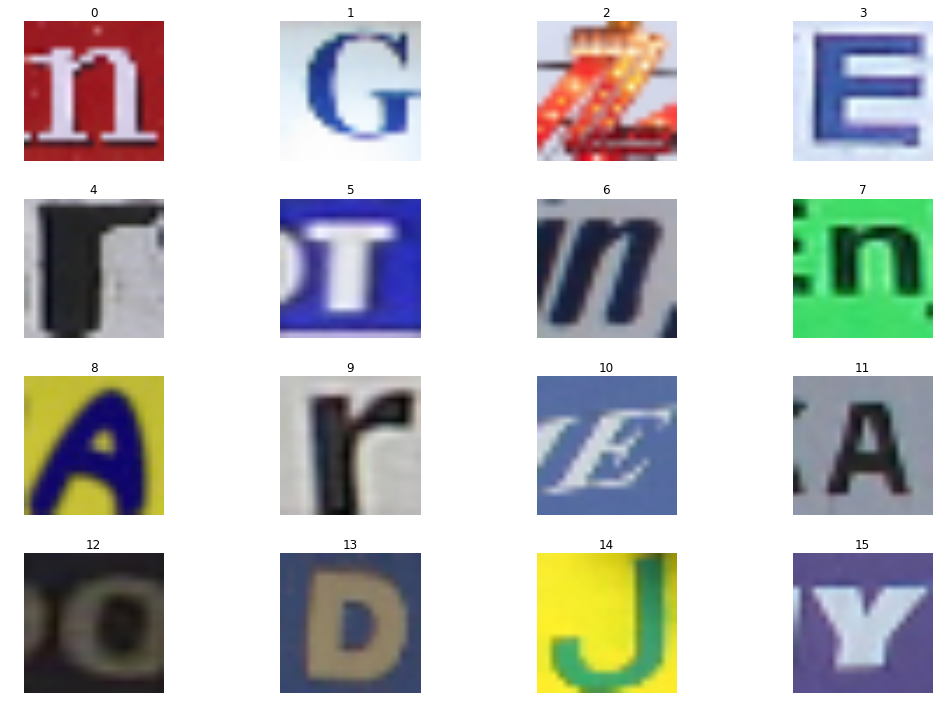

In [8]:
draw_multi_plot(trainX)

In [9]:
trainY_array[0:16]

['n',
 'G',
 'Z',
 'E',
 'r',
 'T',
 'n',
 'n',
 'A',
 'r',
 'E',
 'A',
 '0',
 'D',
 'J',
 'Y']

### 라벨링 재정의 된듯 하다!

In [10]:
from keras.backend import image_dim_ordering
image_dim_ordering()

Using TensorFlow backend.


'tf'

In [11]:
def make_config(img_row, img_col, filter_size=3, epoch=1, batch_size=128, layer_filter1=32, layer_filter2=64, layer_filter3=128):
    config_dict = {
        "epoch":epoch,
        "batch_size":batch_size,
        "img_row":img_row,
        "img_col":img_col,
        "filter_size":filter_size,
        "filter1":layer_filter1,
        "filter2":layer_filter2,
        "filter3":layer_filter3,
    }
    return config_dict

In [14]:
config = make_config(20, 20, layer_filter1=64, layer_filter2=128)
config

{'batch_size': 128,
 'epoch': 1,
 'filter1': 64,
 'filter2': 128,
 'filter3': 128,
 'filter_size': 3,
 'img_col': 20,
 'img_row': 20}

In [15]:
import keras.models as kmodel
import keras.layers.convolutional as conv
import keras.layers.core as core

In [16]:
cnn1 = kmodel.Sequential()
cnn1.add(conv.Convolution2D(config['filter1'], config['filter_size'], config['filter_size'], 
                            activation='relu', input_shape=(config['img_row'], config['img_col'], 3), border_mode='same'))
cnn1.add(conv.Convolution2D(config['filter1'], config['filter_size'], config['filter_size'], activation='relu', border_mode='same'))
cnn1.add(conv.MaxPooling2D(strides=(2,2))) # 2*2칸중 가장 큰 값으로 정한다

# L2
cnn1.add(conv.Convolution2D(config['filter2'], config['filter_size'], config['filter_size'], activation='relu', border_mode='same'))
cnn1.add(conv.Convolution2D(config['filter2'], config['filter_size'], config['filter_size'], activation='relu', border_mode='same'))
cnn1.add(conv.MaxPooling2D(strides=(2,2)))

cnn1.add(core.Flatten()) # 내용물을 1차원으로 쭉 피는 역할을 한다
cnn1.add(core.Dense(500, activation='relu')) # Fully Connected Layer. 뉴런의 갯수는 500로 한다.
cnn1.add(core.Dense(class_size, activation='softmax')) # Fully Connected Softmax 로 마지막에 클래스별 확률값을 구해낸다.
cnn1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 20, 20, 64)    1792        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 20, 20, 64)    36928       convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 10, 10, 64)    0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 10, 10, 128)   73856       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [17]:
cnn1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn1

In [18]:
cnn1.fit(trainX[10:,:,:,:], trainY[10:], batch_size=config['batch_size'], nb_epoch=30, verbose=1)

Epoch 1/30
6273/6273 [==============================] - 60s - loss: 4.1011 - acc: 0.0655    
Epoch 2/30
6273/6273 [==============================] - 51s - loss: 3.8105 - acc: 0.0596    
Epoch 3/30
6273/6273 [==============================] - 51s - loss: 3.7833 - acc: 0.0730    
Epoch 4/30
6273/6273 [==============================] - 52s - loss: 3.7541 - acc: 0.0934    
Epoch 5/30
6273/6273 [==============================] - 51s - loss: 2.8092 - acc: 0.3176    
Epoch 6/30
6273/6273 [==============================] - 51s - loss: 1.9716 - acc: 0.4923    
Epoch 7/30
6273/6273 [==============================] - 51s - loss: 1.6580 - acc: 0.5666    
Epoch 8/30
6273/6273 [==============================] - 51s - loss: 1.2810 - acc: 0.6558    
Epoch 9/30
6273/6273 [==============================] - 51s - loss: 1.0212 - acc: 0.7188    
Epoch 10/30
6273/6273 [==============================] - 51s - loss: 0.7808 - acc: 0.7730    
Epoch 11/30
6273/6273 [==============================] - 52s - loss: 

### Keras 에서는 본인들의 모듈을 저장하는데 pickle 을 사용하지 않기를 권장한다.
https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

from keras.models import load_model<br>
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'<br>
model = load_model('my_model.h5')

In [28]:
cnn1.save('JuliaByKeras-exp2.h5')

## 저장한 Keras Model 를 불러와 작업할때는 다음과 같이 한다.

In [6]:
from keras.models import load_model

In [7]:
cnn = load_model('JuliaByKeras-exp2.h5')
cnn

In [8]:
cnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 20, 20, 64)    1792        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 20, 20, 64)    36928       convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 10, 10, 64)    0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 10, 10, 128)   73856       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [19]:
from sklearn.preprocessing import LabelEncoder

In [20]:
encoder = LabelEncoder()
encoder.fit(trainY_array)
encoder.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c',
       'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
       'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], 
      dtype='<U1')

In [22]:
import keras.utils.np_utils as kutils

In [23]:
encoded_Y = encoder.transform(trainY_array)
dummy_Y = kutils.to_categorical(encoded_Y)
dummy_Y

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [25]:
yPred = cnn1.predict_classes(trainX[0:10,:,:,:])
yPred

10/10 [==============================] - 0s


array([49, 16, 55, 14, 29, 29, 35, 24, 10, 53])

In [26]:
encoder.inverse_transform(yPred)

array(['n', 'G', 't', 'E', 'T', 'T', 'Z', 'O', 'A', 'r'], 
      dtype='<U1')

IndexError: index 10 is out of bounds for axis 0 with size 10

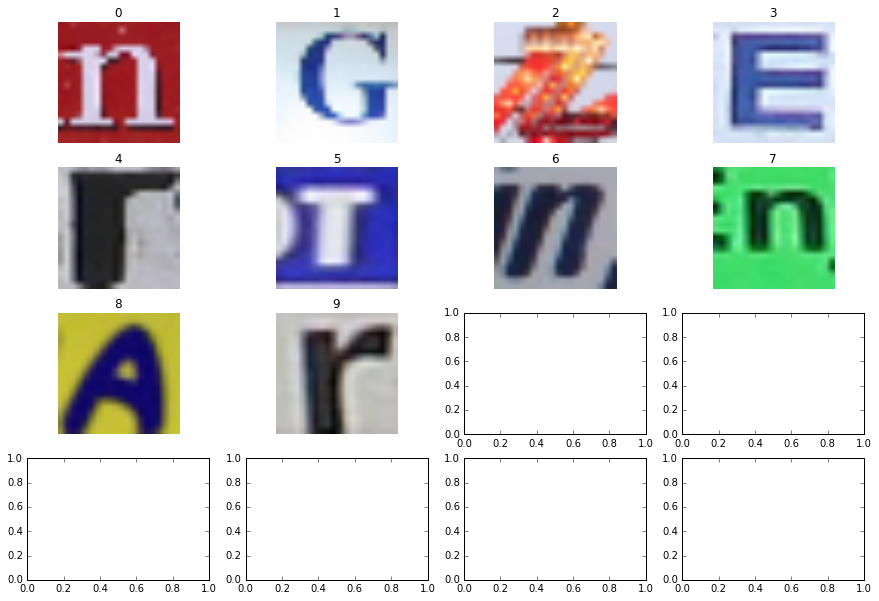

In [27]:
draw_multi_plot(trainX[0:10,:,:,:])